In [1]:
import os
import pandas as pd
import numpy as np

In [255]:
import numpy as np
from datetime import datetime

def computeDistance(startPoint, endPoint):
    return np.sqrt(((startPoint[0]-endPoint[0])**2)+((startPoint[1]-endPoint[1])**2))

def getSideFromRadius(Radius):
    
#     scale_factor = 1144/33.4772
    scale_factor = (955 - 130)/33.4772
    # 2m is the approximated distance of waist to drop ceiling for all participants.
    # 1144/33.4772 was emprically found to convert distances in real world to pixel distances.
    # It is function of input image/map resoloution.
    
    ceilingToWaist = 2 * scale_factor
    
    return int(np.sqrt(np.abs((Radius**2)-(ceilingToWaist**2))))


def getRoom(Loc):

    x=Loc[0]
    y=Loc[1]

    if 200 < x < 430 and 310 < y < 920:
        room = "ActivityArea"

    elif 550 < x < 750 and 200 < y < 950:
        room = 'LC'

    elif 1060 < x < 1260 and 200 < y < 950:
        room = 'RC'    

    elif 600 < x < 1210 and 130 < y < 200:
        room = 'Kitchen' 

    elif 750 < x <= 1260 and 680 < y < 800:
        room='Lounge'

    elif 1400 < x < 1480 and 320 < y < 730:
        room='Staff Zone'  

    else:
        room='Transition Zones'

    return room

In [256]:
import pandas as pd
import numpy as np

from itertools import permutations


def locator(BLE_DATA):
    """You need to pass a dataframe into the form of Time (timestamp form),
    ID, RSSi and PI value into the locator function. The locator function
    returns a dataframe with location, rooms and the time at that location

    Args:
        BLE_DATA (pd.DataFrame): input DataFrame containing bluetooth hits data

    Returns:
        (pd.DataFrame): final locations DataFrame
    """

    # The selected hyperparameters are as follows based on our grid search optimization technique
    startTime = BLE_DATA["Time"].tolist()[0]
    endTime = BLE_DATA["Time"].tolist()[-2]

    startTime = float(startTime)
    endTime = float(endTime)
    # Loading Pi X and Y Locations on Map
    locations = np.loadtxt(
        "PiLocations.csv",
        delimiter=",",
        dtype={"names": ("Pi", "X", "Y"), "formats": ("i", "i", "i")},
        skiprows=1,
    )
    Locations = {}

    for location in locations:
        Locations[location[0]] = (location[1], location[2])

    tframe = 25  # 5s was selected as the window length
    nextp = startTime + tframe
    sTime = startTime
    location = []
    Time_loc = []
    rooms = []
    path_x = []
    path_y = []

    NPT = []
    NHT = []

    scale_factor = (955 - 130) / 33.4772

    dataframe = []

    while nextp <= endTime:
        temp = BLE_DATA[(BLE_DATA["Time"] >= sTime) & (BLE_DATA["Time"] <= nextp)]

        # Choose the moving type to be slide(1)/step(2)

        # The best method based on the hyperparameter tuning was the step method so we can put SS = 2
        # Also the best weight set was S6 which is provided below

        W = [0.7, 0.2, 0.1]
        w1, w2, w3 = W[0], W[1], W[2]

        RHSI_METHOD = 1
        SS = 2

        if SS == 1:
            sTime = sTime + 1
            nextp = sTime + tframe

        else:
            sTime = sTime + tframe
            nextp = nextp + tframe

        numberOfCircles = 0
        radii = []
        RADIUSINM = []

        HitPiIDs, NumOfHits = np.unique(temp["PI"], return_counts=True)
        # print(f"Hit Pi IDs = {HitPiIDs}")
        N = 3.5  # N = 3.5 is a function of environment (Hyperparameter)

        NP = len(HitPiIDs)  # number of Pi's

        if NP == 0:
            NH = 0  # max number of hits
        else:
            NH = np.max(NumOfHits)

        for PiID in HitPiIDs:
            RSSI = temp[temp["PI"] == PiID].RSSI.mean()
            radiusInM = 10 ** (
                (-73 - RSSI) / (10 * N)
            )  # You hard code the M1RSSI into -73dbm

            if radiusInM > 10:
                radiusInM = 10

            RADIUSINM.append(radiusInM)
            radii.append(getSideFromRadius(int(radiusInM * scale_factor)))

        radii = np.array(radii)

        if len(HitPiIDs) == 0:
            # (1160,405) modified to nan - it does not make sense to initialize randomly when there is no information
            center_coordinates =  (np.nan, np.nan)#(1160, 405)
            # print("HitPiIDs is 0")
            # center_coordinates = (np.nan, np.nan)

        if len(HitPiIDs) == 1:
            Pi = int(PiID)
            X, Y = Locations[Pi]
            center_coordinates = (int(X * 1830 / 2432), int(Y * 1167 / 1632))
            radius = radii[0]

        if len(HitPiIDs) > 1:
            perm = permutations(range(0, len(HitPiIDs)), 2)
            perm = list(perm)
            estimatedLocation = np.zeros((len(perm), 2))
            weight = np.zeros(len(perm))

            # Method 1 -- RHSI-Agg: Method number: 0

            if RHSI_METHOD == 0:
                for n, _ in enumerate(perm):
                    Pi1 = int(HitPiIDs[perm[n][0]])
                    Pi2 = int(HitPiIDs[perm[n][1]])
                    X1, Y1 = (
                        Locations[Pi1][0] * 1830 / 2432,
                        Locations[Pi1][1] * 1167 / 1632,
                    )
                    X2, Y2 = (
                        Locations[Pi2][0] * 1830 / 2432,
                        Locations[Pi2][1] * 1167 / 1632,
                    )
                    r1 = radii[perm[n][0]]
                    r2 = radii[perm[n][1]]

                    estimatedLocation[n, :] = [
                        int(X1 + (r1 / (r1 + r2)) * (X2 - X1)),
                        int(Y1 + (r1 / (r1 + r2)) * (Y2 - Y1)),
                    ]
                    weight[n] = NumOfHits[perm[n][0]] + NumOfHits[perm[n][1]]

                weighted_loc = estimatedLocation * weight[:, None]
                weighted_sum_x = np.sum(weighted_loc[:, 0]) / np.sum(weight)
                weighted_sum_y = np.sum(weighted_loc[:, 1]) / np.sum(weight)
                center_coordinates = (int(weighted_sum_x), int(weighted_sum_y))
                radius = int(1.5 * scale_factor)

            # Method 2 -- RHSI-Edge: Method number: 1
            else:
                for n in range(0, len(perm)):
                    Pi1 = int(HitPiIDs[perm[n][0]])
                    Pi2 = int(HitPiIDs[perm[n][1]])
                    X1, Y1 = (
                        Locations[Pi1][0] * 1830 / 2432,
                        Locations[Pi1][1] * 1167 / 1632,
                    )
                    X2, Y2 = (
                        Locations[Pi2][0] * 1830 / 2432,
                        Locations[Pi2][1] * 1167 / 1632,
                    )

                    weight[n] = NumOfHits[perm[n][0]] + NumOfHits[perm[n][1]]
                    r1 = getSideFromRadius(
                        int(
                            RADIUSINM[perm[n][0]]
                            * NumOfHits[perm[n][0]]
                            / weight[n]
                            * scale_factor
                        )
                    )
                    r2 = getSideFromRadius(
                        int(
                            RADIUSINM[perm[n][1]]
                            * NumOfHits[perm[n][1]]
                            / weight[n]
                            * scale_factor
                        )
                    )

                    estimatedLocation[n, :] = [
                        int(X1 + (r1 / (r1 + r2)) * (X2 - X1)),
                        int(Y1 + (r1 / (r1 + r2)) * (Y2 - Y1)),
                    ]

                weighted_loc = estimatedLocation
                weighted_sum_x = np.sum(weighted_loc[:, 0]) / len(weighted_loc[:, 0])
                weighted_sum_y = np.sum(weighted_loc[:, 1]) / len(weighted_loc[:, 1])
                center_coordinates = (int(weighted_sum_x), int(weighted_sum_y))
                radius = int(1.5 * scale_factor)

        if (np.isnan(center_coordinates[0]) == False and np.isnan(center_coordinates[1]) == False):
            if len(location) >= 2:
                if (
                    computeDistance(
                        (location[-1][0], location[-1][1]),
                        (location[-2][0], location[-2][1]),
                    )
                    != 0
                ):
                    x_MA = (
                        w1 * center_coordinates[0]
                        + w2 * location[-1][0]
                        + w3 * location[-2][0]
                    )
                    y_MA = (
                        w1 * center_coordinates[1]
                        + w2 * location[-1][1]
                        + w3 * location[-2][1]
                    )
                    center_coordinates = (x_MA, y_MA)

            location.append(center_coordinates)
            rooms.append(getRoom(center_coordinates))
            Time_loc.append(int(nextp))

    data = {"location": location, "rooms": rooms, "Time_loc": Time_loc}
        # dataframe = pd.DataFrame(data)
    dataframe.append(pd.DataFrame(data))

    return pd.concat(dataframe) if len(dataframe) > 0 else None


In [257]:
dfs = []
fname = '/home/naveenb/vital_ws/EP6/EP6_multimodal_barun/multimodal_integration/ble/data/BLE_DATA_June_24.csv'

data = pd.read_csv(fname, sep=",", header=None, names=["Time", "ID", "RSSI", "PI"])

In [258]:
dfs.append(data.copy())
dfs = pd.concat(dfs)
dfs = dfs.reset_index(drop=True)
dfs_sorted = dfs.sort_values(dfs.columns[0], ascending=True)
dfs_sorted

,Time,ID,RSSI,PI
1,1719226839.4500673,de:28:8e:55:25:67,-83,163
2,1719226842.442581,de:28:8e:55:25:67,-78,163
3,1719226909.01549,de:28:8e:55:25:67,-81,133
4,1719226933.1566503,de:28:8e:55:25:67,-82,133
5,1719226942.18053,de:28:8e:55:25:67,-82,133
...,...,...,...,...
1937,1719284341.1926005,de:28:8e:55:25:67,-84,124
1938,1719284361.2440455,de:28:8e:55:25:67,-80,124
1939,1719284387.4216788,de:28:8e:55:25:67,-81,124
1940,1719284397.4674768,de:28:8e:55:25:67,-82,124


In [259]:
dfs.columns[0]

'Time'

In [260]:
dfs_sorted.drop(dfs_sorted.tail(1).index,inplace=True)
dfs_sorted

,Time,ID,RSSI,PI
1,1719226839.4500673,de:28:8e:55:25:67,-83,163
2,1719226842.442581,de:28:8e:55:25:67,-78,163
3,1719226909.01549,de:28:8e:55:25:67,-81,133
4,1719226933.1566503,de:28:8e:55:25:67,-82,133
5,1719226942.18053,de:28:8e:55:25:67,-82,133
...,...,...,...,...
1936,1719284336.0369756,de:28:8e:55:25:67,-82,124
1937,1719284341.1926005,de:28:8e:55:25:67,-84,124
1938,1719284361.2440455,de:28:8e:55:25:67,-80,124
1939,1719284387.4216788,de:28:8e:55:25:67,-81,124


In [226]:
dfs_sorted_time = dfs_sorted
dfs_sorted_time['Time'] = pd.to_datetime(dfs_sorted['Time'],unit='s', utc=True)
dfs_sorted_time

<ipython-input-226-b4fdbb0b985d>:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  dfs_sorted_time['Time'] = pd.to_datetime(dfs_sorted['Time'],unit='s', utc=True)


,Time,ID,RSSI,PI
1,2024-06-24 11:01:20+00:00,de:28:8e:55:25:67,-83,163
2,2024-06-24 11:01:20+00:00,de:28:8e:55:25:67,-78,163
3,2024-06-24 11:01:20+00:00,de:28:8e:55:25:67,-81,133
4,2024-06-24 11:01:20+00:00,de:28:8e:55:25:67,-82,133
5,2024-06-24 11:01:20+00:00,de:28:8e:55:25:67,-82,133
...,...,...,...,...
1936,2024-06-25 02:59:12+00:00,de:28:8e:55:25:67,-82,124
1937,2024-06-25 02:59:12+00:00,de:28:8e:55:25:67,-84,124
1938,2024-06-25 02:59:12+00:00,de:28:8e:55:25:67,-80,124
1939,2024-06-25 02:59:12+00:00,de:28:8e:55:25:67,-81,124


In [243]:
dfs_sorted_time.iloc[1291]
# imu start time 06/13/24 12:27:45.301415    dfs_sorted.iloc[630]
# imu end time 06/13/24 12:32:35.195309      dfs_sorted.iloc[730]
# dfs_crop_new = dfs_sorted[1364:1430]

Time    2024-06-24 18:31:28+00:00
ID              de:28:8e:55:25:67
RSSI                          -80
PI                            124
Name: 1292, dtype: object

In [251]:
dfs_sorted_time.iloc[1298]

Time    2024-06-24 18:59:12+00:00
ID              de:28:8e:55:25:67
RSSI                          -86
PI                            124
Name: 1299, dtype: object

In [261]:
dfs_crop_new = dfs_sorted#[1291:1298]*1.934
dfs_sorted = dfs_crop_new

In [262]:

dfs_sorted["Time"] = dfs_sorted["Time"].astype(float)
dfs_sorted["RSSI"] = dfs_sorted["RSSI"].astype(int)
dataframe = locator(dfs_sorted)

<ipython-input-256-4abfd8ce6221>:26: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  locations = np.loadtxt(


In [263]:
# Extracting x and y coordinates from the 'location' column
dataframe['x'] = dataframe['location'].apply(lambda loc: loc[0])
dataframe['y'] = dataframe['location'].apply(lambda loc: loc[1])

In [264]:
dataframe

,location,rooms,Time_loc,x,y
0,"(1231, 920)",RC,1719226889,1231.000000,920.000000
1,"(1160, 699)",RC,1719226939,1160.000000,699.000000
2,"(1167.1, 721.0999999999999)",RC,1719226964,1167.100000,721.100000
3,"(1183.82, 773.42)",RC,1719226989,1183.820000,773.420000
4,"(1215.174, 870.794)",RC,1719227014,1215.174000,870.794000
...,...,...,...,...,...
998,"(1126.32368, 702.88536)",RC,1719284214,1126.323680,702.885360
999,"(1126.1449759999998, 702.396552)",RC,1719284239,1126.144976,702.396552
1000,"(1126.0613632, 702.1678464)",RC,1719284264,1126.061363,702.167846
1001,"(1126.02677024, 702.07322448)",RC,1719284364,1126.026770,702.073224


In [265]:
dataframe_sorted = dataframe.sort_values(dataframe.columns[2], ascending=True)
dataframe_sorted['Time_loc'] = pd.to_datetime(dataframe_sorted['Time_loc'],unit='s', utc=True)
dataframe_sorted

,location,rooms,Time_loc,x,y
0,"(1231, 920)",RC,2024-06-24 11:01:29+00:00,1231.000000,920.000000
1,"(1160, 699)",RC,2024-06-24 11:02:19+00:00,1160.000000,699.000000
2,"(1167.1, 721.0999999999999)",RC,2024-06-24 11:02:44+00:00,1167.100000,721.100000
3,"(1183.82, 773.42)",RC,2024-06-24 11:03:09+00:00,1183.820000,773.420000
4,"(1215.174, 870.794)",RC,2024-06-24 11:03:34+00:00,1215.174000,870.794000
...,...,...,...,...,...
998,"(1126.32368, 702.88536)",RC,2024-06-25 02:56:54+00:00,1126.323680,702.885360
999,"(1126.1449759999998, 702.396552)",RC,2024-06-25 02:57:19+00:00,1126.144976,702.396552
1000,"(1126.0613632, 702.1678464)",RC,2024-06-25 02:57:44+00:00,1126.061363,702.167846
1001,"(1126.02677024, 702.07322448)",RC,2024-06-25 02:59:24+00:00,1126.026770,702.073224


In [275]:
dataframe_sorted.iloc[561]
# imu start time 06/13/24 12:27:45.301415    dfs_sorted.iloc[515]
# imu end time 06/13/24 12:32:35.195309      dfs_sorted.iloc[555]
# dfs_crop_new = dfs_sorted[1364:1430][551, 561]

location    (1126.0000005453105, 702.0000014915847)
rooms                                            RC
Time_loc                  2024-06-24 19:00:39+00:00
x                                       1126.000001
y                                        702.000001
Name: 561, dtype: object

In [286]:
dataframe_sorted_plot = dataframe_sorted[551:561]#[551:561]#[515:555]

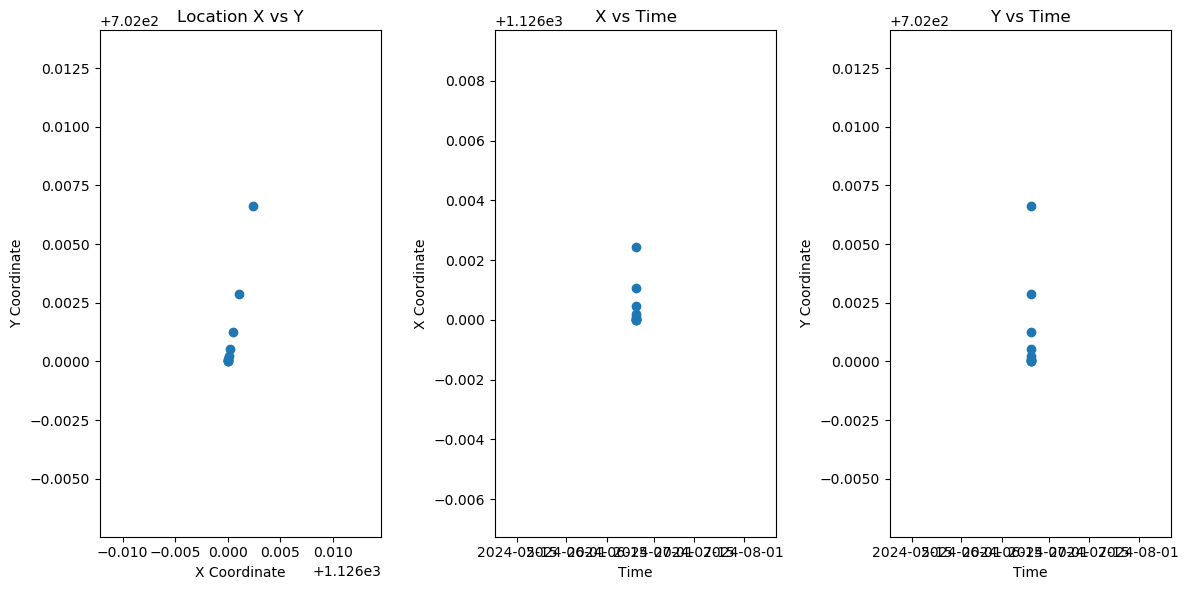

In [287]:
# Naveen 
import matplotlib.pyplot as plt
# Plot location x vs y
# Plot location x vs y
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.scatter(dataframe_sorted_plot['x'], dataframe_sorted_plot['y'])
plt.title('Location X vs Y')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Plot x vs time
plt.subplot(1, 3, 2)
plt.scatter(dataframe_sorted_plot['Time_loc'], dataframe_sorted_plot['x'])
plt.title('X vs Time')
plt.xlabel('Time')
plt.ylabel('X Coordinate')

# Plot y vs time
plt.subplot(1, 3, 3)
plt.scatter(dataframe_sorted_plot['Time_loc'], dataframe_sorted_plot['y'])
plt.title('Y vs Time')
plt.xlabel('Time')
plt.ylabel('Y Coordinate')

plt.tight_layout()
plt.show()

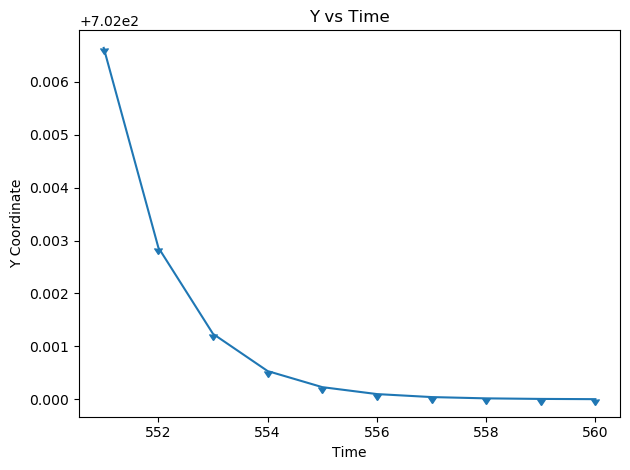

In [282]:
# # Plot y vs time
# num = -900 
plt.plot( dataframe_sorted_plot['y'][551: 561],marker=11)
plt.title('Y vs Time')
plt.xlabel('Time')
plt.ylabel('Y Coordinate')

plt.tight_layout()
plt.show()

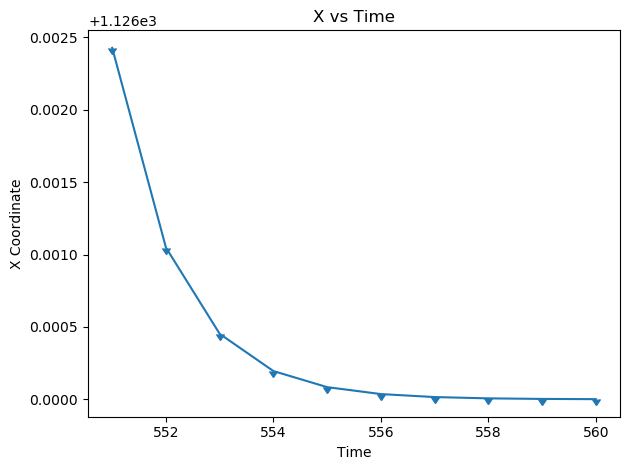

In [281]:
plt.plot( dataframe_sorted_plot['x'][551: 561],marker=11)  #[445:515]
plt.title('X vs Time')
plt.xlabel('Time')
plt.ylabel('X Coordinate')

plt.tight_layout()
plt.show()

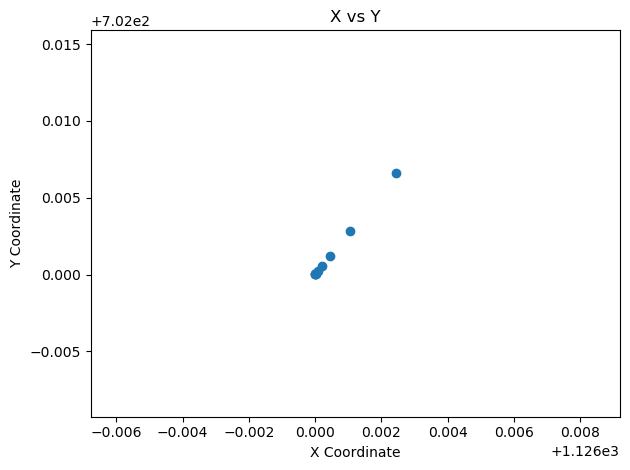

In [283]:
# # Plot y vs time
# num = -900 
plt.scatter(dataframe['x'][551:561], dataframe['y'][551:561])
plt.title('X vs Y')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.tight_layout()
plt.show()

In [25]:
#dataframe['Time_loc']

In [284]:
dataframe_sorted_plot

,location,rooms,Time_loc,x,y
0,"(1231, 920)",RC,2024-06-24 11:01:29+00:00,1231.000000,920.000000
1,"(1160, 699)",RC,2024-06-24 11:02:19+00:00,1160.000000,699.000000
2,"(1167.1, 721.0999999999999)",RC,2024-06-24 11:02:44+00:00,1167.100000,721.100000
3,"(1183.82, 773.42)",RC,2024-06-24 11:03:09+00:00,1183.820000,773.420000
4,"(1215.174, 870.794)",RC,2024-06-24 11:03:34+00:00,1215.174000,870.794000
...,...,...,...,...,...
998,"(1126.32368, 702.88536)",RC,2024-06-25 02:56:54+00:00,1126.323680,702.885360
999,"(1126.1449759999998, 702.396552)",RC,2024-06-25 02:57:19+00:00,1126.144976,702.396552
1000,"(1126.0613632, 702.1678464)",RC,2024-06-25 02:57:44+00:00,1126.061363,702.167846
1001,"(1126.02677024, 702.07322448)",RC,2024-06-25 02:59:24+00:00,1126.026770,702.073224


<ipython-input-183-6b2954f625c9>:3: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  locations = np.loadtxt(


1830x1167


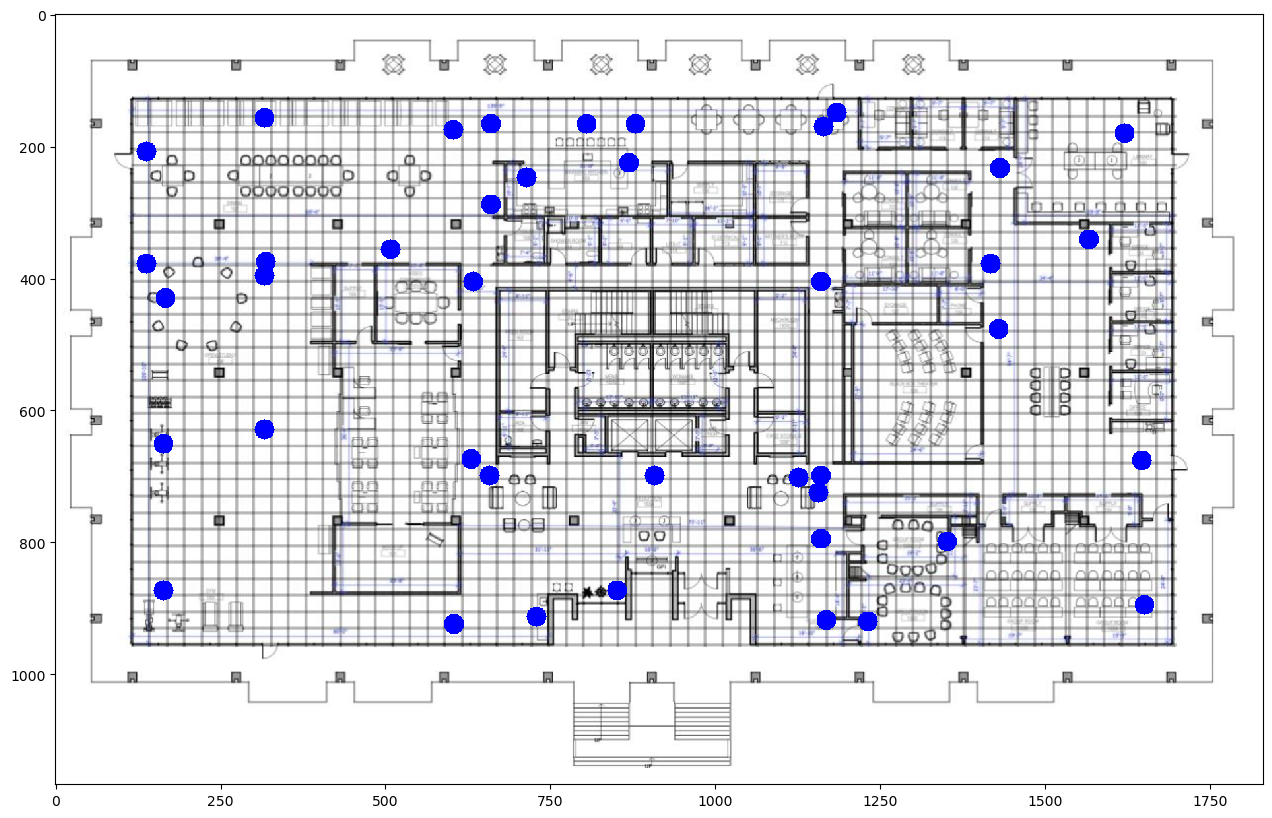

In [183]:
import cv2
# Loading Pi X and Y Locations on Map
locations = np.loadtxt(
        "PiLocations.csv",
        delimiter=",",
        dtype={"names": ("Pi", "X", "Y"), "formats": ("i", "i", "i")},
        skiprows=1,)
    
Pi, X, Y = [], [], []

for location in locations:
    Pi.append(location[0])
    X.append(location[1])
    Y.append(location[2])
    
data = {'Pi': Pi, 'X': X, 'Y': Y}
df = pd.DataFrame(data)


img = cv2.imread("ep6_floorplan_measured_half_gridded_1_meter.jpg", cv2.IMREAD_COLOR)
img = cv2.resize(img, (610*3, 389*3))


wid = img.shape[1]
hgt = img.shape[0]

print(str(wid) + "x" + str(hgt))

color=[0,0,255] 

for i in range(0, len(df)):
    image = cv2.circle(img, (int(df['X'][i] * 1830/2432), int(df['Y'][i] * 1167/1632)), 15, color , -1)

plt.figure(figsize=(20,10))
plt.imshow(image)
plt.show()

In [184]:
import matplotlib.patches as mpatches

def plot_floormap_with_tracks(df, og_color, color, img_loc='ep6_floorplan_measured_half_gridded_1_meter.jpg', room=None):
    #print(f'Len of df = {len(df)}')
    #plt.figure(figsize=(20, 10), layout='constrained')
    plt.figure(figsize=(20,10))
    image = cv2.imread(img_loc)
    image = cv2.resize(image, (610*3, 389*3))
    image_new = None
    
    for i in range(len(df) - 1):
        #print(int(df['x'][i]), int(df['y'][i]))
        image_new = cv2.circle(image, (int(df['x'][i]), int(df['y'][i])), 7, color, -1)
        #image_new = cv2.arrowedLine(image_new, (int(df['x'][i]),int(df['y'][i])), (int(df['x'][i+1]),int(df['y'][i+1])), (255,0,0), 2,tipLength = 0.1)
        # image_new = cv2.putText(img, str(i), (int(dfm['X'][i]), int(dfm['Y'][i])), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2, cv2.LINE_AA)
    # og_color = [c/255 for c in og_color]
    # color = [c/255 for c in color]
  
    # gt_patch = mpatches.Patch(color=og_color, label='Ground Truth')
    # pred_patch = mpatches.Patch(color=color, label='Computed tracks')
    # plt.legend(handles=[gt_patch, pred_patch], loc='lower right', fontsize=15)
    plt.imshow(image_new)
    plt.show()
    if room:
        plt.title(f'Localization in {room}')

In [288]:
plot_floormap_with_tracks(dataframe_sorted_plot, og_color=[255, 0, 0], color=[0, 0, 255])

Len of df = 10


KeyError: 0

In [24]:
#dataframe_sorted_plot['x']

In [289]:
def plot_floormap_with_tracks(df, og_color, color, img_loc='ep6_floorplan_measured_half_gridded_1_meter.jpg', room=None):
    print(f'Len of df = {len(df)}')
    plt.figure(figsize=(20,10))
    image = cv2.imread(img_loc)
    image = cv2.resize(image, (610*3, 389*3))
    
    for i in range(len(df) - 1):
        # Draw line from current point to next point
        image = cv2.line(image, (int(df['x'][i]), int(df['y'][i])), (int(df['x'][i+1]), int(df['y'][i+1])), color, 2)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if room:
        plt.title(f'Localization in {room}')
    plt.show()

In [290]:
plot_floormap_with_tracks(dataframe_sorted_plot, og_color=[255, 0, 0], color=[0, 0, 255])

Len of df = 10


KeyError: 0

Len of df = 1003


<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

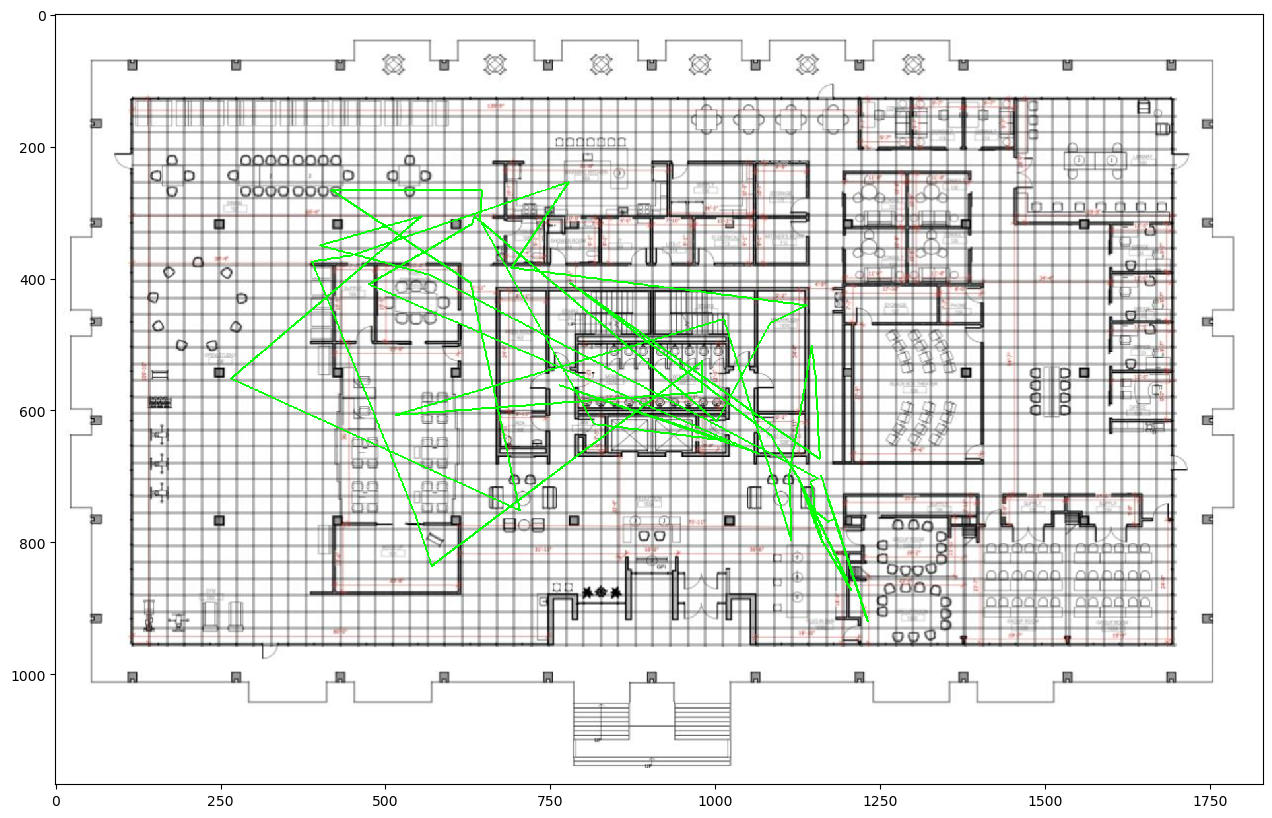

In [291]:
plot_floormap_with_tracks(dataframe, og_color=[255, 0, 0], color=[0, 255, 0])

In [ ]:
[1291:1298]/1.934

In [252]:
1291/1.934

667.5284384694933

In [253]:
1298/1.934

671.147880041365

In [ ]:
[325:378]